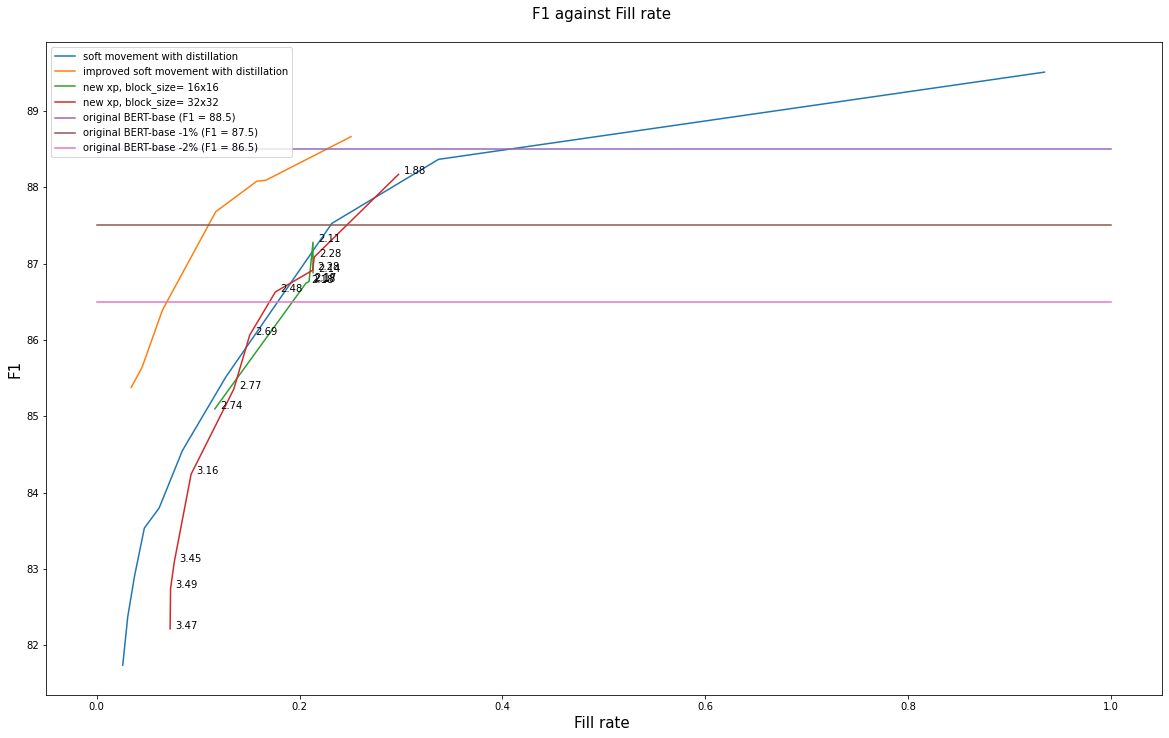

In [32]:
import pandas
import math
import numpy
from matplotlib import pyplot as pyplot
import os
import json
from pathlib import Path

#%matplotlib widget

class Plotter():
    def __init__(self, filename):
        self.filename = filename
        
    def read_checkpoint_info(self):
        j = json.load(open(self.filename))

        base_time = j["base_speed_report"]["eval_elapsed_time"]

        points = []
        max_speedup = 1.0
        for name, checkpoint in j["checkpoints"].items():
            try:
                #print(name, list(checkpoint.keys()))
                speedup = base_time / checkpoint["speed"]["eval_elapsed_time"]
                speedup = max(1.0, speedup)
            except:
                speedup = 1.0
            max_speedup=max(max_speedup, speedup)
            p = Path(name)
            eval_metrics = json.load(open(p / "eval_metrics.json"))
            sparsity_report = json.load(open(p / "sparsity_report.json"))
            sparsity = 1.0 - (sparsity_report["linear_nnz"] / sparsity_report["linear_total"])
            sparse_args = json.load(open(p / "sparse_args.json"))
            points.append(dict(speedup=speedup, **eval_metrics, sparsity=sparsity, sparse_args=sparse_args, path=name))
        return points

    def read_reference_entries(self):
        defaults = dict(size=1, inner_sparsity=1, cols=1, rows=1, epochs=10)
        ret = dict(local_movement_pruning=[], soft_movement_with_distillation=[])
    
        xcel_file_name = "/home/lagunas/devel/hf/block_movement_pruning/notebooks/mvmt_pruning.xlsx"
        xcel = pandas.read_excel(xcel_file_name, index_col=0, sheet_name="Details - SQuAD")  
        xcel = pandas.DataFrame(xcel)
        for i, (r, d) in enumerate(xcel.iterrows()):
            if i > 2:
                if str(d[2]) != "nan":
                    name = d[2]
                    name_parts = name.split("_")
                    if name.startswith("topK_1.0"):
                        key = "local_movement_pruning"
                    elif name.startswith("l1_with_distil"):
                        key = "soft_movement_with_distillation"
                    else:
                        key = None
                    if key != None:
                        d = dict(name=name, fill_rate= d[3] / 100.0, exact=d[4], f1=d[5])

                        d.update(defaults)
                        ret[key].append(d)
        return ret

    def check(self, d, equals, not_equals):
        for k,v in equals.items():
            if d[k] != v:
                return False
        for k,v in not_equals.items():
            if d[k] == v:
                return False
        return True
            
    def is_new_xp(self, xp):
        compare = dict(attention_pruning_method = 'sigmoied_threshold',
                       dense_block_cols = 1,
                       dense_block_rows = 1,
                       dense_pruning_method='sigmoied_threshold:1d_alt',
                       initial_warmup=1,
                       final_warmup=10,
                       regularization="l1")
                
        compare_different=dict(attention_block_cols = 1,
                               attention_block_rows = 1,                       
                               distil_teacher_name_or_path=None)

        sparse_args = xp["sparse_args"]
        if self.check(sparse_args, compare, compare_different):
            cols = sparse_args['attention_block_cols']
            rows = sparse_args['attention_block_rows']
            if cols == 768:
                return None
            return f"new xp, block_size= {rows}x{cols}"
        else:
            return None
    

    
    def is_improved_mvmt_pruning(self, xp):
        compare = dict(attention_block_cols = 1,
                       attention_block_rows = 1,
                       attention_pruning_method = 'sigmoied_threshold',
                       dense_block_cols = 1,
                       dense_block_rows = 1,
                       dense_pruning_method='sigmoied_threshold',
                       initial_warmup=1,    
                       final_warmup=10,
                       regularization="l1")
        
        compare_different=dict(distil_teacher_name_or_path=None)
        
        sparse_args = xp["sparse_args"]
        if self.check(sparse_args, compare, compare_different):
            return "improved soft movement with distillation"
        else:
            return None

    
    def is_longer_final_warmup(self, xp):
        compare = dict(attention_block_cols = 32,
                       attention_block_rows = 32,
                       attention_pruning_method = 'sigmoied_threshold',
                       dense_block_cols = 1,
                       dense_block_rows = 1,
                       dense_pruning_method='sigmoied_threshold:1d_alt',
                       initial_warmup=1,
                       final_warmup=15,
                       regularization="l1")
        
        compare_different=dict(distil_teacher_name_or_path=None)

        sparse_args = xp["sparse_args"]
        if self.check(sparse_args, compare, compare_different):
            return "new method, longer final warmup (15 instead of 10)"
        else:
            return None
        
    def is_attention_rows(self, xp):
        compare = dict(attention_block_cols = 768,
                       attention_block_rows = 1,
                       attention_pruning_method = 'sigmoied_threshold',
                       dense_block_cols = 1,
                       dense_block_rows = 1,
                       dense_pruning_method='sigmoied_threshold:1d_alt',
                       initial_warmup=1,
                       final_warmup=10,
                       regularization="l1")
        
        compare_different=dict(distil_teacher_name_or_path=None)

        sparse_args = xp["sparse_args"]
        if self.check(sparse_args, compare, compare_different):
            return "new method, attention pruned with rows"
        else:
            return None
        
    def is_block_sparse(self, xp):
        compare = dict(attention_block_cols = 32,
                       attention_block_rows = 32,
                       attention_pruning_method = 'sigmoied_threshold',
                       dense_block_cols = 32,
                       dense_block_rows = 32,
                       dense_pruning_method='sigmoied_threshold',
                       initial_warmup=1,
                       final_warmup=10,
                       regularization="l1")
        
        compare_different=dict(distil_teacher_name_or_path=None)

        sparse_args = xp["sparse_args"]
        if self.check(sparse_args, compare, compare_different):
            return "block_sparse"
        else:
            return None
                                                                                
    
    def categorize(self, xp):
        checkpoint_index = int(xp["path"].split("/")[-1].split("-")[-1])
        if checkpoint_index <= 75000:
            return "small_epoch"
        
        new_xp = self.is_new_xp(xp)
        if new_xp:
            return new_xp
        improved_mvmt_pruning = self.is_improved_mvmt_pruning(xp)
        if improved_mvmt_pruning:
            return improved_mvmt_pruning
        
        longer_warmup = self.is_longer_final_warmup(xp)
        if longer_warmup:
            return longer_warmup
        
        attention_rows = self.is_attention_rows(xp)
        if attention_rows:
            return attention_rows        
        
        block_sparse = self.is_block_sparse(xp)
        if block_sparse:
            return block_sparse
        
        return "misc"
    
    def process_checkpoint(self, checkpoint):
        d = checkpoint
        ret = dict(fill_rate=1.0 - d["sparsity"], f1=d["f1"])
        
        speedup = d["speedup"]
        if speedup > 1:
            ret["speedup"] = speedup
        return ret
    
    def checkpoints_prepare(self, checkpoints):
        ret = {}
        for checkpoint in checkpoints:
            cat = self.categorize(checkpoint)
            if cat == None:
                continue
            if cat not in ret:
                ret[cat] = []
            processed = self.process_checkpoint(checkpoint)
            #if cat == "misc":
            #    print(json.dumps(checkpoint["sparse_args"], indent=4))
            ret[cat].append(processed)
        return ret
    
                        
    def plot(self):
        checkpoints = self.read_checkpoint_info()

        reference_entries = self.read_reference_entries()
        
        labels = ["soft movement with distillation"]
        parts = [reference_entries["soft_movement_with_distillation"]]
        
        checkpoints_plot_info = self.checkpoints_prepare(checkpoints)
        
        category_keys = list(checkpoints_plot_info.keys())
        category_keys.sort()
        
    #    select = ['block_sparse', 'improved soft movement with distillation', 'misc', 'new method, attention pruned with rows', 'new method, longer final warmup (15 instead of 10)', 'new xp, block_size= 16x16', 'new xp, block_size= 32x32', 'new xp, block_size= 64x32', 'small_epoch']
        select = ['improved soft movement with distillation', 'new xp, block_size= 32x32', 'new xp, block_size= 16x16']
    
        
        for k in category_keys:
            if select is not None and k not in select:
                continue
            v = checkpoints_plot_info[k]
            if k in ["small_epoch"]:
                continue
            labels.append(k)
            parts.append(v)
        
        
        markers = ["o", "v", "s", "+", "v"]

        fig = pyplot.figure(figsize=(20,12))
        ax1 = fig.add_subplot(111)

        for i, data in enumerate(parts):
            #if i == 0 or i > 2:
            #    continue
            data.sort(key = lambda x : x["fill_rate"])
            x = [e["fill_rate"] for e in data]
            y = [e["f1"] for e in data]
            s = numpy.array([math.sqrt(e["fill_rate"]) for e in data])
            #c = numpy.array([e["epochs"] for e in data])
        
           # plt.xscale("log")
            #pyplot.scatter(x, y, s=s* 200, cmap='viridis', alpha=1.0, label = labels[i]) #, marker=markers[i]) # cool
            pyplot.plot(x, y, label = labels[i]) #, marker=markers[i]) # cool
            
            try:
                for i, txt in enumerate(x):
                    ax1.annotate("%0.2f" % data[i]["speedup"], (x[i]+0.005, y[i]+0.005))
            except Exception as e:
                pass
            
        for i in range(3):
            f1 = 88.5 - i
            pyplot.plot([0,1], [88.5 - i] * 2, label=f"original BERT-base {'' if i == 0 else str(-i)+'% '}(F1 = {f1})")
        
        pyplot.legend(loc='upper left');
        #pyplot.xscale('log')
        
        #c = plt.colorbar()
        #c.ax.set_title("Number of epochs")
        #pyplot.xlim(0.0, 0.2)
        #pyplot.ylim(84, 89)
        XLabel = 'Fill rate '
        #XLabel = "speedup"
        fontsize = 15
        pyplot.xlabel(XLabel, fontsize=fontsize)
        YLabel = "F1"
        pyplot.ylabel(YLabel, fontsize=fontsize)
        title = '%s against %s\n' % (YLabel, XLabel)
        pyplot.title(title, fontsize=fontsize)
        
p = Plotter("results3.json")
p.plot()




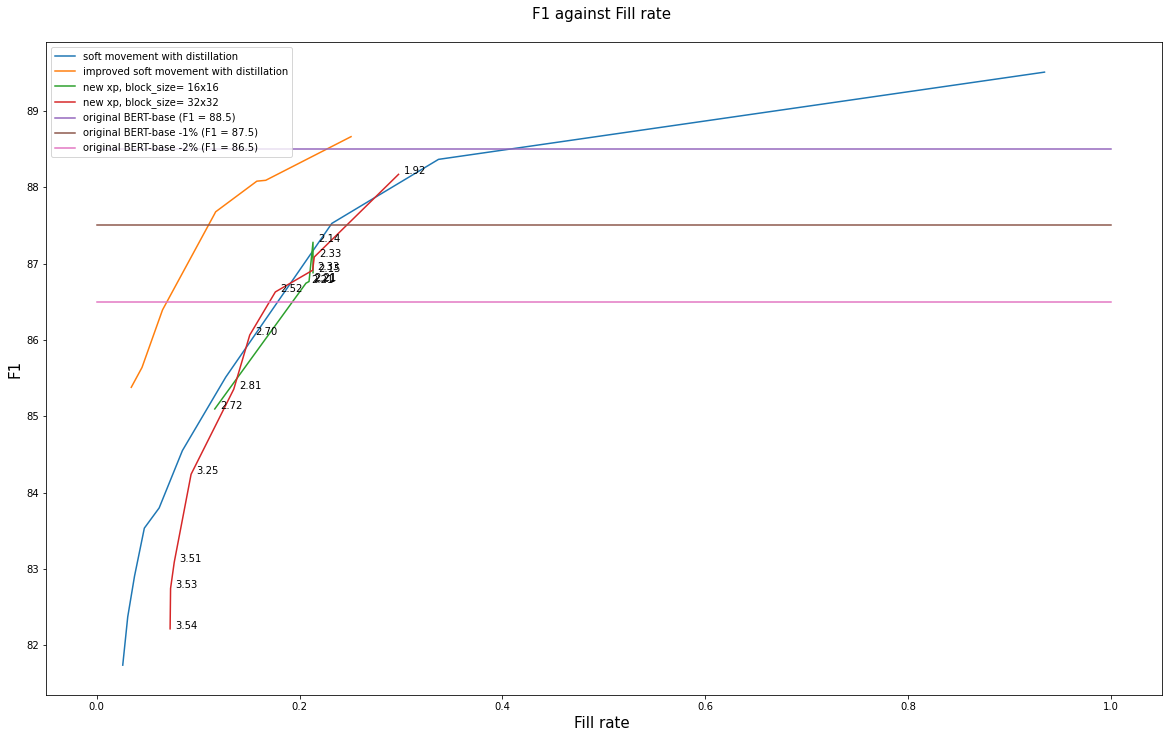

In [33]:
        
p = Plotter("results.json")
p.plot()